In [85]:
import numpy as np
import os
# import re
# import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
# import netCDF4
import sys
from DA_operators import operator_clm_SMAP, operator_clm_FLX, haversine_distance
import matplotlib.pyplot as plt
import pickle

# folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v13_1y_xy16_loc16_a16_dzeta04_iter3_FLXv2_inflate105'
i_iter = 7
folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter%i' % i_iter

if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
from settings_copy import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap


In [86]:
settings_gen

{'file_indi': '/p/project/cjibg36/kaandorp2/eTSMP_setups/setup_eclm_cordex_444x432_v8/input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa',
 'Ks_sample_xy': 10,
 'Ks_sample_z': 5,
 'Ks_mode': 'ml',
 'Ks_plot': True,
 'a_sample_xy': 10,
 'a_sample_z': 5,
 'a_plot': True,
 'n_sample_xy': 10,
 'n_sample_z': 5,
 'n_plot': True,
 'poros_sample_xy': 10,
 'poros_sample_z': 5,
 'poros_plot': True,
 'file_slopex': '/p/project/cjibg36/kaandorp2/eTSMP_setups/setup_eclm_cordex_444x432_v8/input_pf/slopex.sa',
 'file_slopey': '/p/project/cjibg36/kaandorp2/eTSMP_setups/setup_eclm_cordex_444x432_v8/input_pf/slopey.sa',
 'slope_sample_xy': 10,
 'slope_plot': True,
 'dir_clm_surf': '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter1/input_clm',
 'file_clm_surf': 'surfdata_EUR-11_hist_16pfts_Irrig_CMIP6_simyr2000_c230808_GLC2000.nc',
 'texture_sample_xy': 16,
 'texture_start_x': 8,
 'texture_start_y': 8,
 'texture

/tmp/ipykernel_6402/1883287172.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1883287172.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1883287172.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1883287172.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6

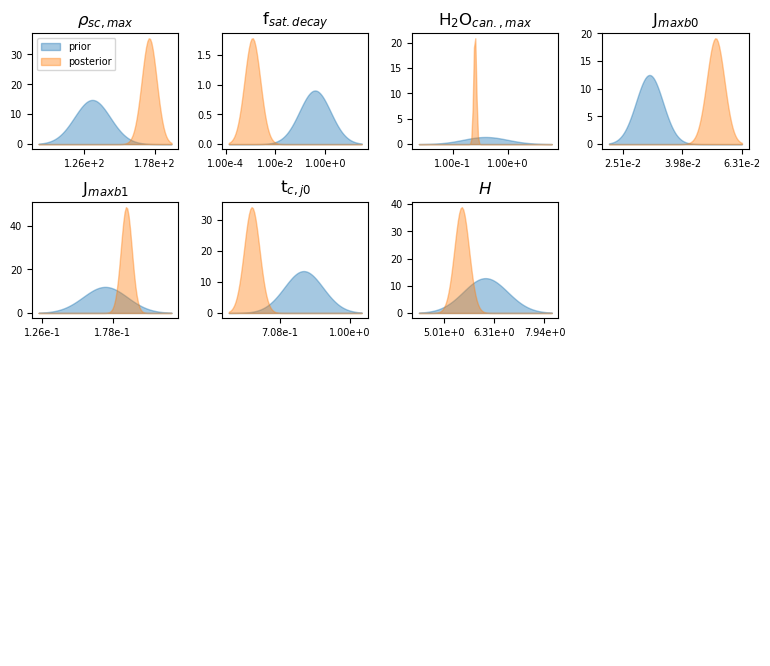

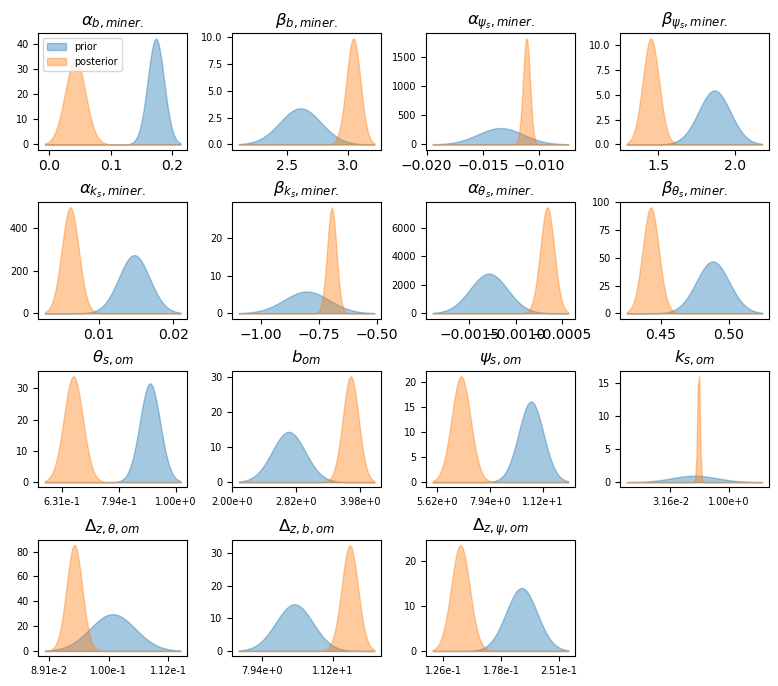

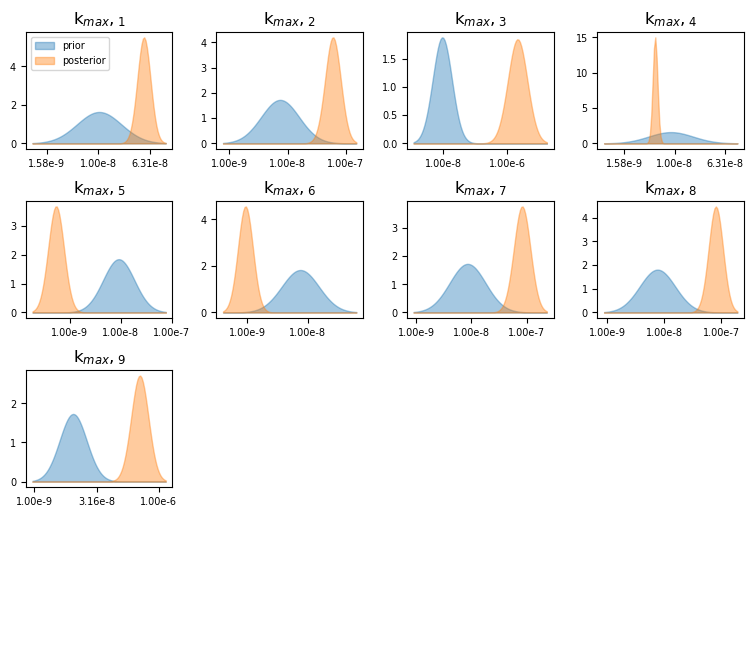

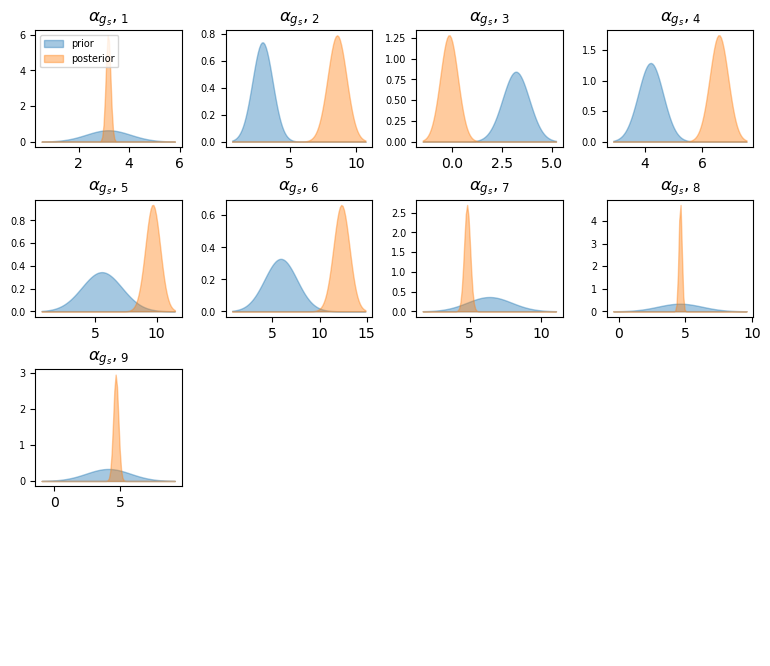

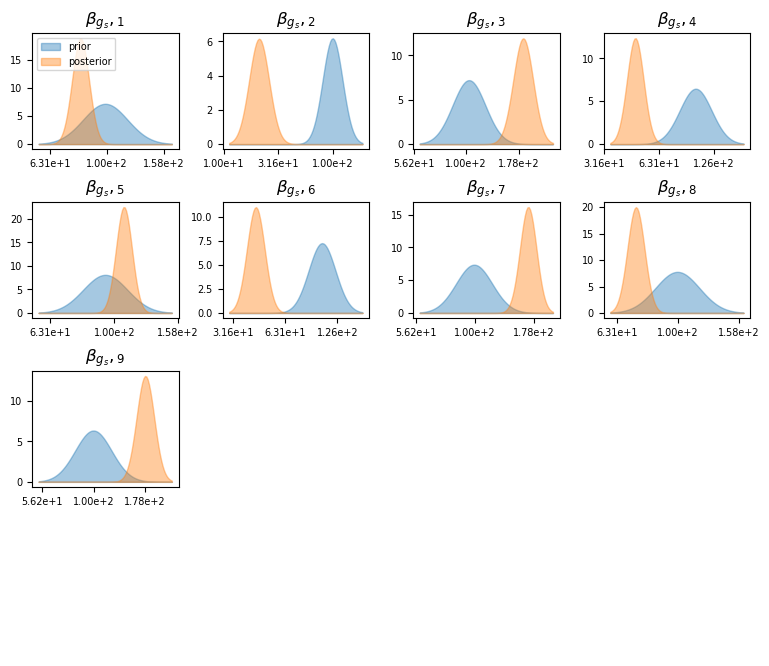

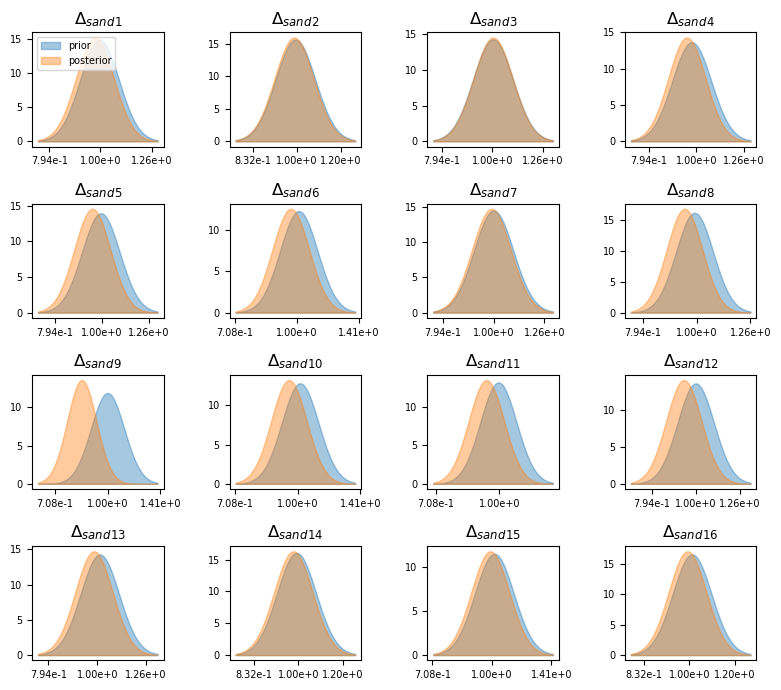

In [87]:

dir_figs = os.path.join(folder_results,'figures/02_prior_post')
if not os.path.exists(dir_figs):
    print('Creating folder to store FLX information: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
%matplotlib inline

def Gaussian(x,m,s):
    return (1/(s*np.sqrt(np.pi)))*np.exp(-.5*((x-m)/s)**2)

def read_paramfiles(list_files):
    for i1,file_ in enumerate(list_files):
        data = np.load(file_)
        if i1 == 0:
            array = np.zeros([0,len(data)])
        array = np.vstack((array,data))
    return array
        

log_scale = {'orgmax_v2':True,
             'fff':True,
             'h2o_canopy_max':True,
             'luna':True,
             'mineral_hydraulic':False,
             'om_hydraulic':True,
             'kmax_v2':True,
             'medlyn_slope_v2':False,
             'medlyn_intercept_v2':True,
             'sandfrac_anom':True,
             'clayfrac_anom':True,
             'orgfrac_anom':True}

symbols =   {'orgmax_v2':r'$\rho_{sc,max}$',
             'fff':r'f$_{sat.decay}$',
             'h2o_canopy_max':r'H$_2$O$_{can.,max}$',
             'luna':[r'J$_{maxb0}$', r'J$_{maxb1}$', r't$_{c,j0}$', r'$H$'],
             'mineral_hydraulic':[r'$\alpha_{b,miner.}$',r'$\beta_{b,miner.}$',
                                  r'$\alpha_{\psi_s,miner.}$',r'$\beta_{\psi_s,miner.}$',
                                  r'$\alpha_{k_s,miner.}$',r'$\beta_{k_s,miner.}$',
                                  r'$\alpha_{\theta_s,miner.}$',r'$\beta_{\theta_s,miner.}$'], 
             'om_hydraulic':[r'$\theta_{s,om}$',r'$b_{om}$',
                             r'$\psi_{s,om}$',r'$k_{s,om}$',
                             r'$\Delta_{z,\theta,om}$',r'$\Delta_{z,b,om}$',
                             r'$\Delta_{z,\psi,om}$'],
             'kmax_v2':r'k$_{max},$',
             'medlyn_slope_v2':r'$\alpha_{g_s},$',
             'medlyn_intercept_v2':r'$\beta_{g_s},$',
             'sandfrac_anom':r'$\Delta_{sand}$',
             'clayfrac_anom':r'$\Delta_{clay}$',
             'orgfrac_anom':r'$\Delta_{om}$'}

figures =   {'orgmax_v2':1,
             'fff':1,
             'h2o_canopy_max':1,
             'luna':1,
             'mineral_hydraulic':2,
             'om_hydraulic':2,
             'kmax_v2':3,
             'medlyn_slope_v2':4,
             'medlyn_intercept_v2':5,
             'sandfrac_anom':6,
             'clayfrac_anom':6,
             'orgfrac_anom':6}

figs_data = {'data_mean_pr':np.array([]),
            'data_std_pr':np.array([]),
            'data_mean_po':np.array([]),
            'data_std_po':np.array([]),
            'i_fig':np.array([]),
            'log':np.array([]),
            'label':[]}

cmap=plt.cm.tab10

for param_ in figures.keys():
    # param_ = 'mineral_hydraulic'

    priors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.000.[0-9][0-9][0-9]*'%(param_))) )
    posteriors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.%3.3i.*'%(param_,i_iter))) )

    prior_vals = read_paramfiles(priors)
    post_vals = read_paramfiles(posteriors)

    figures[param_]

    figs_data['data_mean_pr'] = np.append(figs_data['data_mean_pr'], prior_vals.mean(axis=0))
    figs_data['data_std_pr'] = np.append(figs_data['data_std_pr'], prior_vals.std(axis=0))
    figs_data['data_mean_po'] = np.append(figs_data['data_mean_po'], post_vals.mean(axis=0))
    figs_data['data_std_po'] = np.append(figs_data['data_std_po'], post_vals.std(axis=0))
    figs_data['i_fig'] = np.append(figs_data['i_fig'], figures[param_]*np.ones(prior_vals.shape[1]))
    figs_data['log'] = np.append(figs_data['log'], log_scale[param_]*np.ones(prior_vals.shape[1],dtype=bool))

    if prior_vals.shape[1]==1:
        app_ = ['']
    else:
        app_ = ['$_{%i}$'%i_ for i_ in range(1,prior_vals.shape[1]+1)]
            
    if type(symbols[param_]) == str:
        list_append = [symbols[param_]+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data['label'].extend(list_append)
    elif type(symbols[param_]) == list:
        figs_data['label'].extend(symbols[param_])
    else:
        list_append = [param_+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data['label'].extend(list_append)
        
        
n_max=4
i_old = 0
i_fig = 0
for i1 in np.arange(len(figs_data['data_mean_pr']))[0:n_max*16+1]:
    
    if i1 == 0 or figs_data['i_fig'][i1] != i_old or c==16:
        i_old = figs_data['i_fig'][i1]
        fig,axes=plt.subplots(4,4,figsize=(8,7))
        c = 0
        
    row_ = c//4
    col_ = c%4
    
    if c == 0:
        label_pr = 'prior'
        label_po = 'posterior'
    else:
        label_pr = None
        label_po = None
        
    x_min = min( (figs_data['data_mean_pr'][i1] - 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] - 3*figs_data['data_std_po'][i1]) )
    x_max = max( (figs_data['data_mean_pr'][i1] + 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] + 3*figs_data['data_std_po'][i1]) )
    x_ = np.linspace(x_min,x_max,100)
    
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(0), alpha=.4, label=label_pr)
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(1), alpha=.4, label=label_po)
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]),'k-')
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]),'r-')
    axes[row_,col_].set_title(figs_data['label'][i1])
    axes[row_,col_].tick_params(axis='y', labelsize=7)
    if c == 0:
        axes[row_,col_].legend(fontsize=7,loc='upper left')
    
    if figs_data['log'][i1] == 1:
        axes[row_,col_].tick_params(axis='x', which='major', labelsize=7)
        axes[row_,col_].xaxis.set_major_locator(plt.MaxNLocator(3))
        labels_ = axes[row_,col_].get_xticks()
        # axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])
        axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
        # axes[row_,col_].tick_params(axis='x', which='major', labelsize=6)
    
    
    if i1==len(figs_data['i_fig'])-1 or c==15: 
        # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
        fig.tight_layout()
        fig.savefig(os.path.join(dir_figs,'%3.3i_prior_post.pdf'%i_fig))
        i_fig+=1
        # plt.close('all')
    else: 
        if figs_data['i_fig'][i1+1] != i_old:
            # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            fig.subplots_adjust(wspace=0.3,hspace=0.45)
            for c_ in range(c+1,16):
                row_ = c_//4
                col_ = c_%4
                axes[row_,col_].set_axis_off()
                
            fig.savefig(os.path.join(dir_figs,'%3.3i_prior_post.pdf'%i_fig))
            i_fig+=1
            # plt.close()
    c += 1

/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter1/input_DA/orgmax_v2.param.000.001.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter3/input_DA/orgmax_v2.param.000.003.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/input_DA/orgmax_v2.param.000.005.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter7/input_DA/orgmax_v2.param.000.007.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter1/input_DA/fff.param.000.001.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter3/input_DA/fff.param.000.003.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/input_DA/fff.param.000.005.000.npy
/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter7/input_DA/fff.param.000.007.000.npy
/p/scratch/cjibg36/kaand

/tmp/ipykernel_6402/1192343044.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1192343044.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1192343044.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6402/1192343044.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6

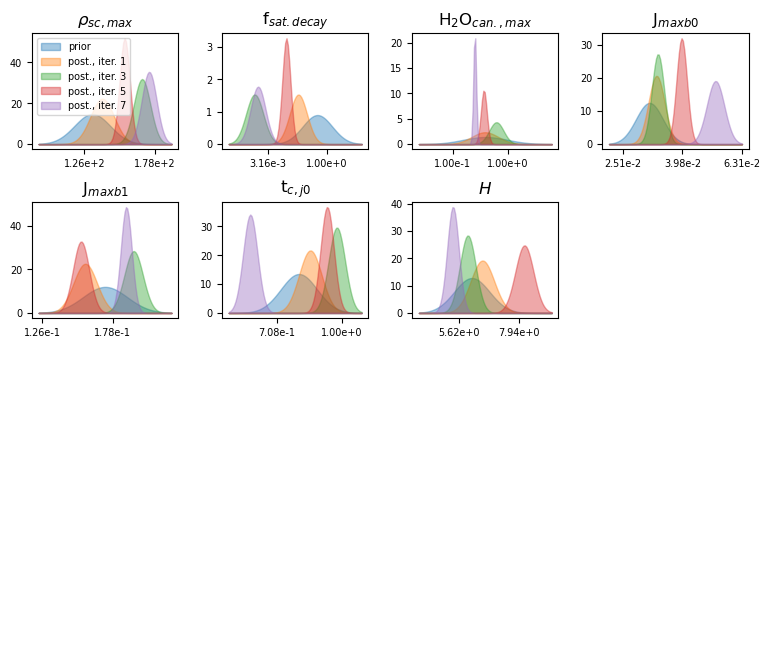

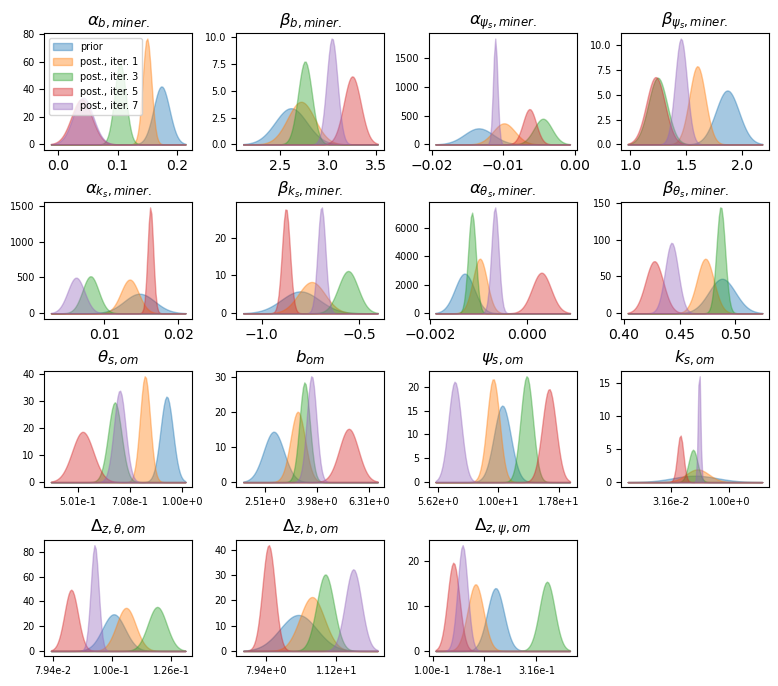

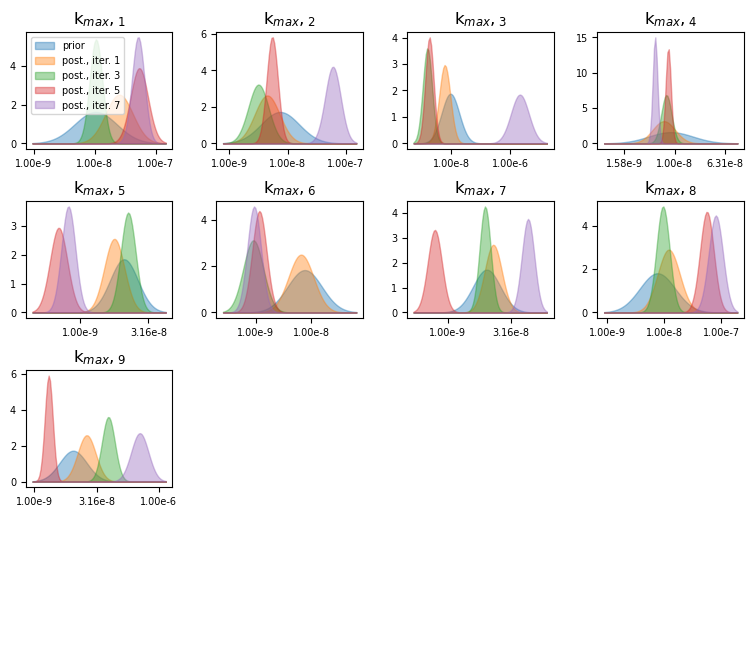

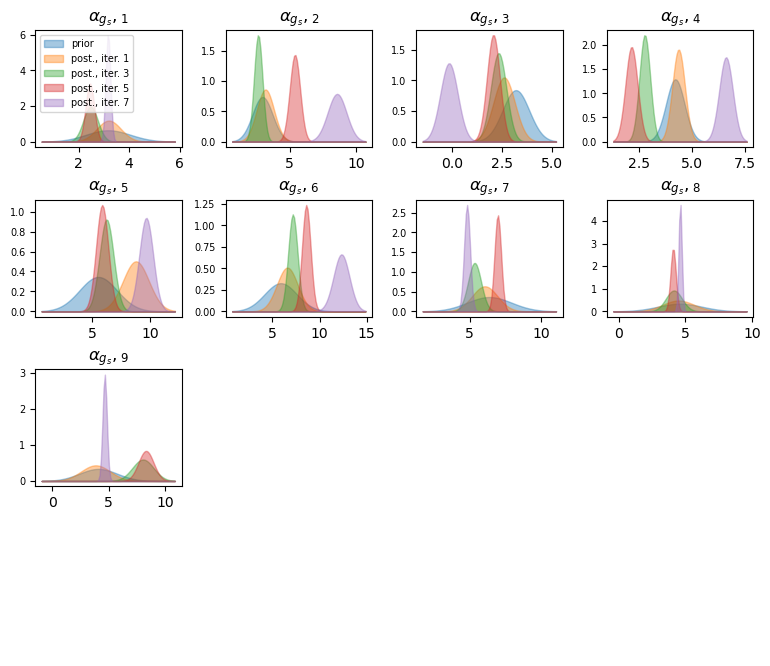

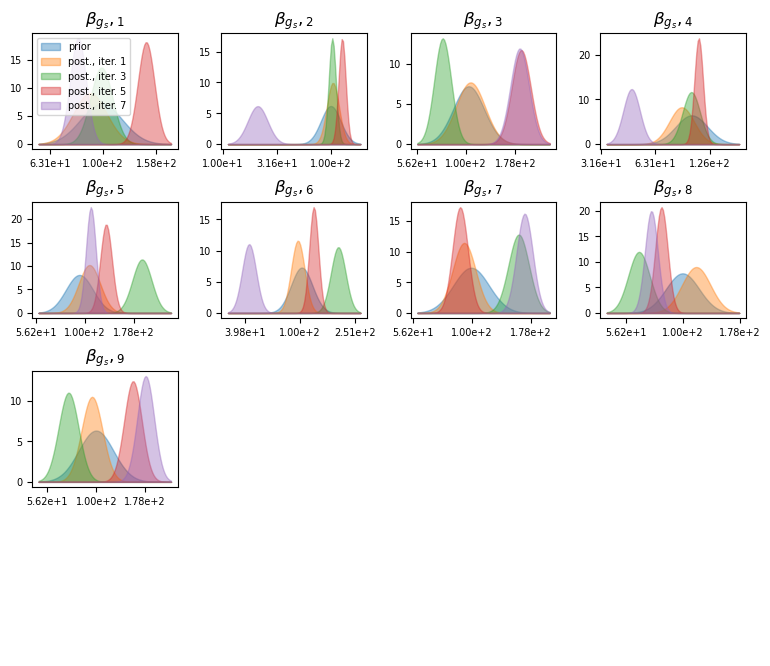

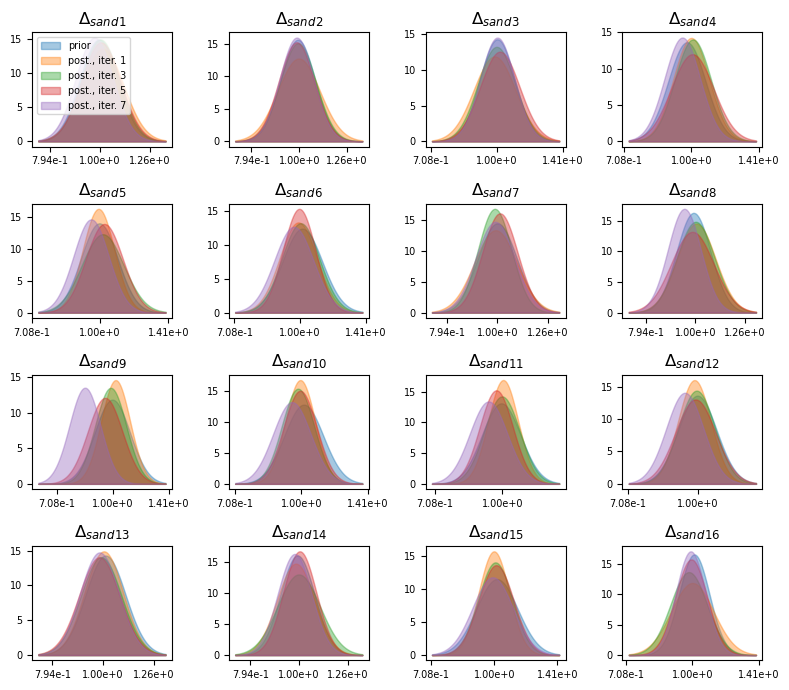

In [88]:

dir_figs = os.path.join(folder_results,'figures/02_prior_post')
if not os.path.exists(dir_figs):
    print('Creating folder to store FLX information: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
%matplotlib inline

def Gaussian(x,m,s):
    return (1/(s*np.sqrt(np.pi)))*np.exp(-.5*((x-m)/s)**2)

def read_paramfiles(list_files):
    for i1,file_ in enumerate(list_files):
        data = np.load(file_)
        if i1 == 0:
            array = np.zeros([0,len(data)])
        array = np.vstack((array,data))
    return array
        

log_scale = {'orgmax_v2':True,
             'fff':True,
             'h2o_canopy_max':True,
             'luna':True,
             'mineral_hydraulic':False,
             'om_hydraulic':True,
             'kmax_v2':True,
             'medlyn_slope_v2':False,
             'medlyn_intercept_v2':True,
             'sandfrac_anom':True,
             'clayfrac_anom':True,
             'orgfrac_anom':True}

symbols =   {'orgmax_v2':r'$\rho_{sc,max}$',
             'fff':r'f$_{sat.decay}$',
             'h2o_canopy_max':r'H$_2$O$_{can.,max}$',
             'luna':[r'J$_{maxb0}$', r'J$_{maxb1}$', r't$_{c,j0}$', r'$H$'],
             'mineral_hydraulic':[r'$\alpha_{b,miner.}$',r'$\beta_{b,miner.}$',
                                  r'$\alpha_{\psi_s,miner.}$',r'$\beta_{\psi_s,miner.}$',
                                  r'$\alpha_{k_s,miner.}$',r'$\beta_{k_s,miner.}$',
                                  r'$\alpha_{\theta_s,miner.}$',r'$\beta_{\theta_s,miner.}$'], 
             'om_hydraulic':[r'$\theta_{s,om}$',r'$b_{om}$',
                             r'$\psi_{s,om}$',r'$k_{s,om}$',
                             r'$\Delta_{z,\theta,om}$',r'$\Delta_{z,b,om}$',
                             r'$\Delta_{z,\psi,om}$'],
             'kmax_v2':r'k$_{max},$',
             'medlyn_slope_v2':r'$\alpha_{g_s},$',
             'medlyn_intercept_v2':r'$\beta_{g_s},$',
             'sandfrac_anom':r'$\Delta_{sand}$',
             'clayfrac_anom':r'$\Delta_{clay}$',
             'orgfrac_anom':r'$\Delta_{om}$'}

figures =   {'orgmax_v2':1,
             'fff':1,
             'h2o_canopy_max':1,
             'luna':1,
             'mineral_hydraulic':2,
             'om_hydraulic':2,
             'kmax_v2':3,
             'medlyn_slope_v2':4,
             'medlyn_intercept_v2':5,
             'sandfrac_anom':6,
             'clayfrac_anom':6,
             'orgfrac_anom':6}

figs_data = {'data_mean_pr':np.array([]),
            'data_std_pr':np.array([]),
            'data_mean_po':np.array([]),
            'data_std_po':np.array([]),
            'i_fig':np.array([]),
            'log':np.array([]),
            'label':[]}

figs_data_all = {}
for i_iter in [1,3,5,7]:
    figs_data_all[i_iter] = {'data_mean_pr':np.array([]),
                            'data_std_pr':np.array([]),
                            'data_mean_po':np.array([]),
                            'data_std_po':np.array([]),
                            'i_fig':np.array([]),
                            'log':np.array([]),
                            'label':[]}

cmap=plt.cm.tab10

for param_ in figures.keys():
    # param_ = 'mineral_hydraulic'

    for i_iter in [1,3,5,7]:
        # figs_data_all[i_iter] = {'data_mean_pr':np.array([]),
        #                         'data_std_pr':np.array([]),
        #                         'data_mean_po':np.array([]),
        #                         'data_std_po':np.array([]),
        #                         'i_fig':np.array([]),
        #                         'log':np.array([]),
        #                         'label':[]}

        folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter%i' % i_iter
        # i_iter = 7

        priors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.000.[0-9][0-9][0-9]*'%(param_))) )
        posteriors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.%3.3i.*'%(param_,i_iter))) )
        print(posteriors[0])
        
        prior_vals = read_paramfiles(priors)
        post_vals = read_paramfiles(posteriors)

        # figures[param_]

        figs_data_all[i_iter]['data_mean_pr'] = np.append(figs_data_all[i_iter]['data_mean_pr'], prior_vals.mean(axis=0))
        figs_data_all[i_iter]['data_std_pr'] = np.append(figs_data_all[i_iter]['data_std_pr'], prior_vals.std(axis=0))
        figs_data_all[i_iter]['data_mean_po'] = np.append(figs_data_all[i_iter]['data_mean_po'], post_vals.mean(axis=0))
        figs_data_all[i_iter]['data_std_po'] = np.append(figs_data_all[i_iter]['data_std_po'], post_vals.std(axis=0))
        figs_data_all[i_iter]['i_fig'] = np.append(figs_data_all[i_iter]['i_fig'], figures[param_]*np.ones(prior_vals.shape[1]))
        figs_data_all[i_iter]['log'] = np.append(figs_data_all[i_iter]['log'], log_scale[param_]*np.ones(prior_vals.shape[1],dtype=bool))

    if prior_vals.shape[1]==1:
        app_ = ['']
    else:
        app_ = ['$_{%i}$'%i_ for i_ in range(1,prior_vals.shape[1]+1)]
            
    if type(symbols[param_]) == str:
        list_append = [symbols[param_]+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data_all[i_iter]['label'].extend(list_append)
    elif type(symbols[param_]) == list:
        figs_data_all[i_iter]['label'].extend(symbols[param_])
    else:
        list_append = [param_+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data_all[i_iter]['label'].extend(list_append)
        
        
n_max=4
i_old = 0
i_fig = 0
c=0
for i1 in np.arange(len(figs_data_all[i_iter]['data_mean_pr']))[0:n_max*16+1]:
    
    if i1 == 0 or figs_data_all[i_iter]['i_fig'][i1] != i_old or c==16:
        i_old = figs_data_all[i_iter]['i_fig'][i1]
        fig,axes=plt.subplots(4,4,figsize=(8,7))
        c = 0
        
    row_ = c//4
    col_ = c%4
    
    if c == 0:
        label_pr = 'prior'
    #     label_po = 'posterior'
    else:
        label_pr = None
    #     label_po = None
        
    x_min = min( (figs_data_all[i_iter]['data_mean_pr'][i1] - 3*figs_data_all[i_iter]['data_std_pr'][i1]), 
                min([figs_data_all[i_iter]['data_mean_po'][i1] - 3*figs_data_all[i_iter]['data_std_po'][i1] for i_iter in [1,3,5,7]]) )
    x_max = max( (figs_data_all[i_iter]['data_mean_pr'][i1] + 3*figs_data_all[i_iter]['data_std_pr'][i1]), 
                max([figs_data_all[i_iter]['data_mean_po'][i1] + 3*figs_data_all[i_iter]['data_std_po'][i1] for i_iter in [1,3,5,7]]) )
    x_ = np.linspace(x_min,x_max,100)

    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data_all[i_iter]['data_mean_pr'][i1],figs_data_all[i_iter]['data_std_pr'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(0), alpha=.4, label=label_pr)
                              
    for i2,i_iter in enumerate([1,3,5,7]):
        if c == 0:
            # label_pr = 'prior'
            label_po = 'post., iter. %i' % i_iter
        else:
            # label_pr = None
            label_po = None

        axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data_all[i_iter]['data_mean_po'][i1],figs_data_all[i_iter]['data_std_po'][i1]), 
                                     y2=np.zeros_like(x_), color=cmap(i2+1), alpha=.4, label=label_po)
        
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]),'k-')
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]),'r-')
    axes[row_,col_].set_title(figs_data_all[i_iter]['label'][i1])
    axes[row_,col_].tick_params(axis='y', labelsize=7)
    if c == 0:
        axes[row_,col_].legend(fontsize=7,loc='upper left')
    
    if figs_data_all[i_iter]['log'][i1] == 1:
        axes[row_,col_].tick_params(axis='x', which='major', labelsize=7)
        axes[row_,col_].xaxis.set_major_locator(plt.MaxNLocator(3))
        labels_ = axes[row_,col_].get_xticks()
        # axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])
        axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
        # axes[row_,col_].tick_params(axis='x', which='major', labelsize=6)
    
    
    if i1==len(figs_data_all[i_iter]['i_fig'])-1 or c==15: 
        # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
        fig.tight_layout()
        fig.savefig(os.path.join(dir_figs,'%3.3i_prior_post.pdf'%i_fig))
        i_fig+=1
        # plt.close('all')
    else: 
        if figs_data_all[i_iter]['i_fig'][i1+1] != i_old:
            # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            fig.subplots_adjust(wspace=0.3,hspace=0.45)
            for c_ in range(c+1,16):
                row_ = c_//4
                col_ = c_%4
                axes[row_,col_].set_axis_off()
                
            fig.savefig(os.path.join('figures','%3.3i_prior_post.pdf'%i_fig))
            i_fig+=1
            # plt.close()
    c += 1

In [44]:
figs_data_all[7]['label'][7:20]

['$\\alpha_{b,miner.}$',
 '$\\beta_{b,miner.}$',
 '$\\alpha_{\\psi_s,miner.}$',
 '$\\beta_{\\psi_s,miner.}$',
 '$\\alpha_{k_s,miner.}$',
 '$\\beta_{k_s,miner.}$',
 '$\\alpha_{\\theta_s,miner.}$',
 '$\\beta_{\\theta_s,miner.}$',
 '$\\theta_{s,om}$',
 '$b_{om}$',
 '$\\psi_{s,om}$',
 '$k_{s,om}$',
 '$\\Delta_{z,\\theta,om}$']

In [62]:
figs_data_all[7]['label'][15]

'$\\theta_{s,om}$'

In [46]:
len(figs_data_all[5]['data_mean_po'])

1294

0 0.4865348331421457 -721.0999697513967
50 0.42538300131573614 -159.486574035984
100 0.36423116948932666 -35.273843246040634
0 0.4272249331474964 -168.7247095466087
50 0.4427433834800023 -81.47541147562579
100 0.45826183381250823 -39.34363077560245


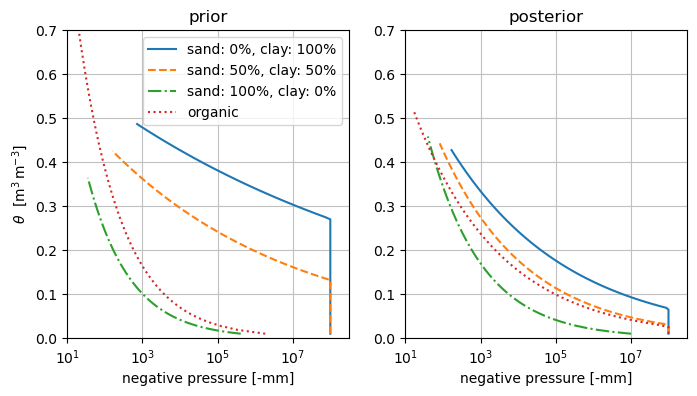

In [75]:
titles = ['prior','posterior']
fig,axes=plt.subplots(1,2,figsize=(8,4) )
for i1,mode_ in enumerate(['data_mean_pr','data_mean_po']):
    for i2,sand_ in enumerate([0,50,100]):
        lstyles = ['-','--','-.',':']
        clay_ = 100 - sand_
        
        theta_sat = figs_data_all[5][mode_][13]*sand_ + figs_data_all[5][mode_][14]
        psi_sat = -10*10**(figs_data_all[5][mode_][9]*sand_ + figs_data_all[5][mode_][10])
        b = figs_data_all[5][mode_][7]*clay_ + figs_data_all[5][mode_][8] 
        
        print(sand_,theta_sat,psi_sat)
        
        theta_plot = np.linspace(0.01,theta_sat,100)
        psi = psi_sat*(theta_plot/theta_sat)**(-b)
        
        psi[psi < -1e8] = -1e8
        axes[i1].semilogx(-psi,theta_plot,lstyles[i2],label=r'sand: %i%%, clay: %i%%' % (sand_,clay_))
    
    theta_som = 10**(figs_data_all[5][mode_][15])
    psi_som = -10**(figs_data_all[5][mode_][17])
    b_om = 10**(figs_data_all[5][mode_][16])
    
    theta_plot = np.linspace(0.01,theta_som,100)
    psi = psi_som*(theta_plot/theta_som)**(-b_om)

    psi[psi < -1e8] = -1e8
    axes[i1].semilogx(-psi,theta_plot,lstyles[3],label='organic')    

    axes[i1].set_ylim(0,0.7)
    axes[i1].set_xlim(1e1,10**(8.5))
    if i1 == 0:
        axes[i1].legend()
        axes[i1].set_ylabel(r'$\theta$  [m$^3\,$m$^{-3}$]')
    axes[i1].set_title(titles[i1])
    axes[i1].set_xlabel('negative pressure [-mm]')
    axes[i1].grid(color='silver')
    
fig.savefig('figures/soil_water_characteristic_curve.png')
fig.savefig('figures/soil_water_characteristic_curve.pdf')


In [66]:
10**(theta_som)

0.5185874578631168

/tmp/ipykernel_3424/2333045001.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])


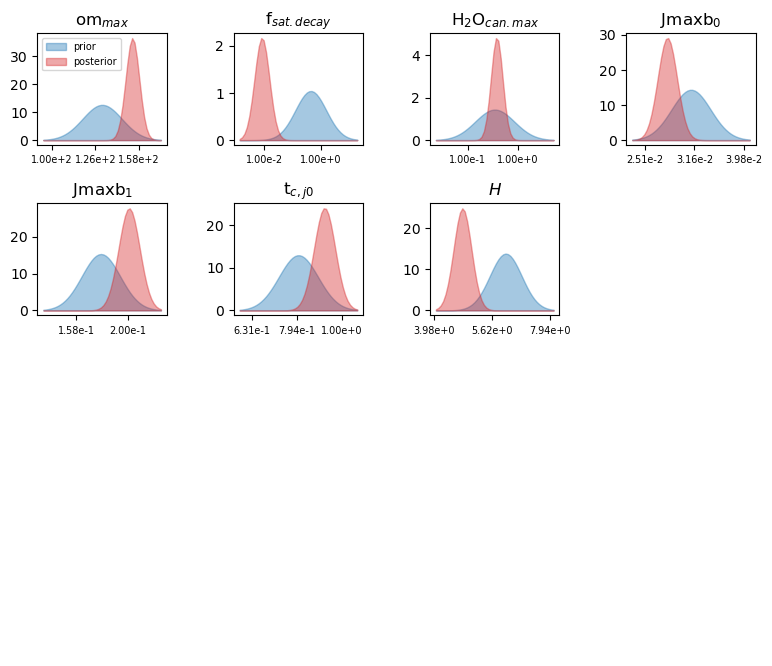

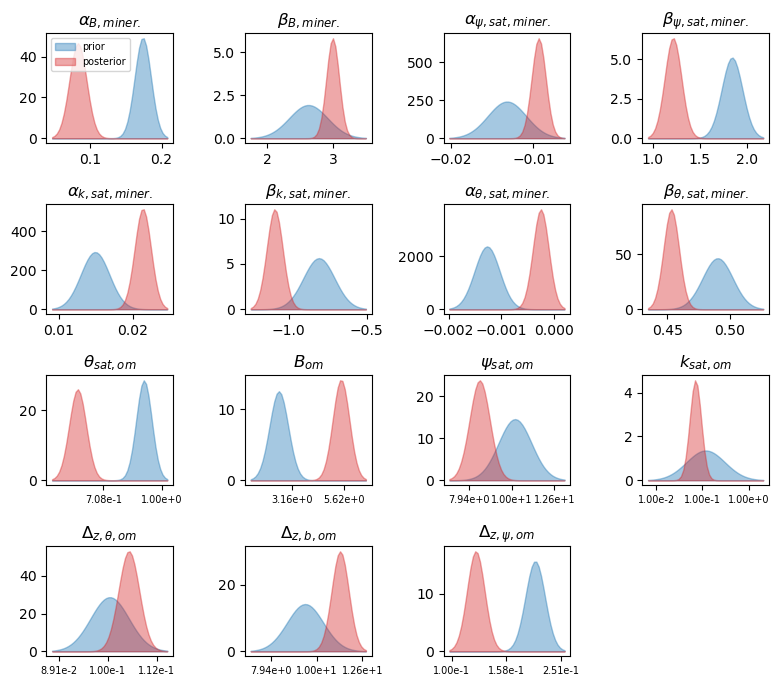

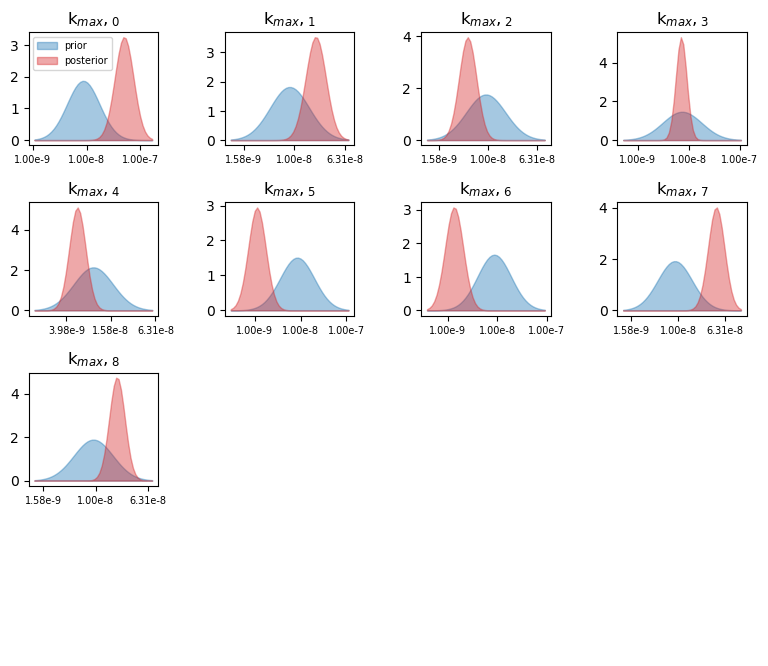

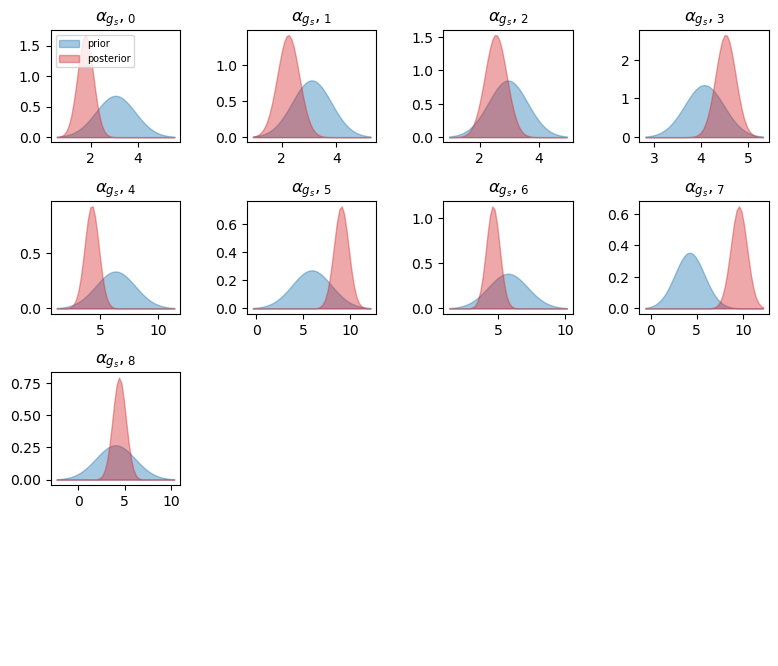

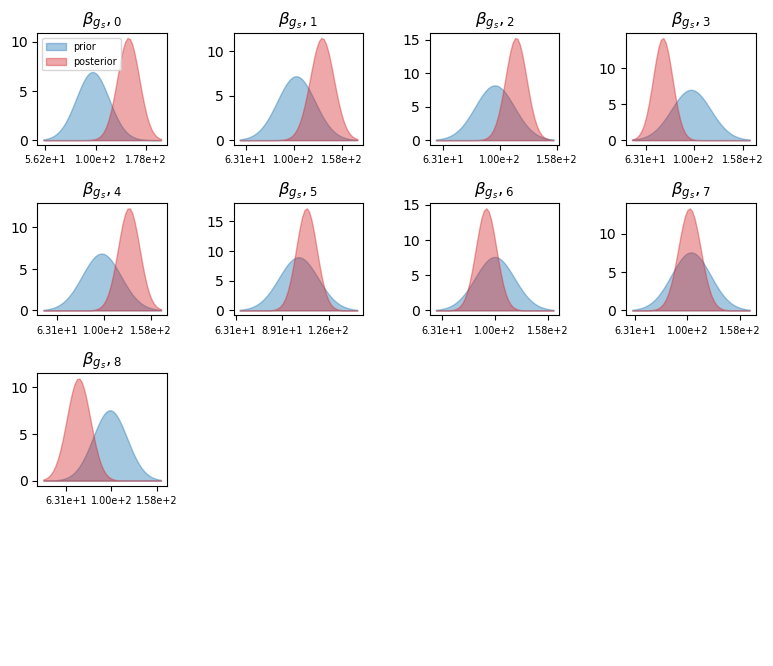

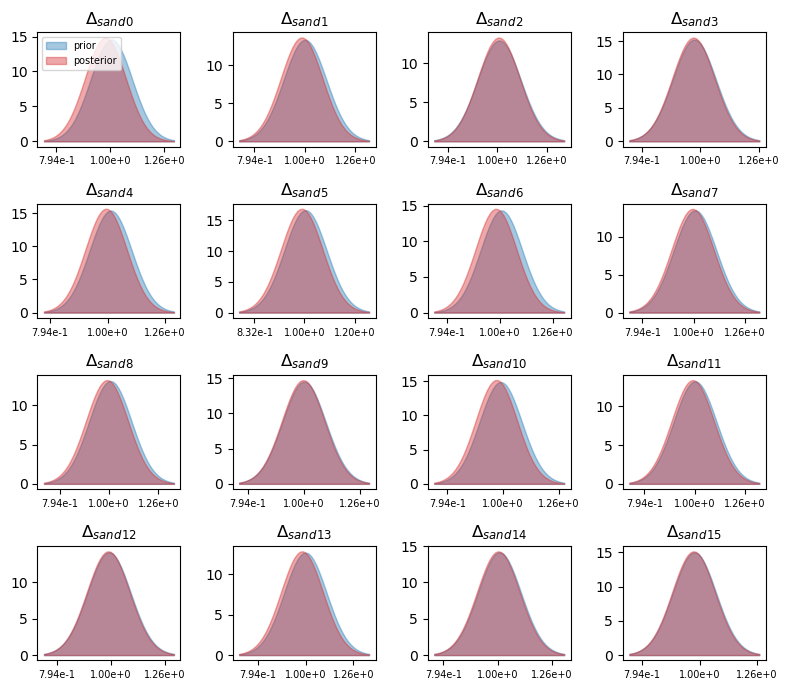

In [120]:

n_max=6
i_old = 0
for i1 in np.arange(len(figs_data['data_mean_pr']))[0:n_max*16+1]:
    
#     if np.isnan(figs_data['i_fig'][i1]):
#         if c==0 or c==16:
#             fig,axes=plt.subplots(4,4,figsize=(8,7))
#             c = 0            
        
    if i1 == 0 or figs_data['i_fig'][i1] != i_old or c==16:
        i_old = figs_data['i_fig'][i1]
        fig,axes=plt.subplots(4,4,figsize=(8,7))
        c = 0
        
    row_ = c//4
    col_ = c%4
    
    if c == 0:
        label_pr = 'prior'
        label_po = 'posterior'
    else:
        label_pr = None
        label_po = None
        
    x_min = min( (figs_data['data_mean_pr'][i1] - 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] - 3*figs_data['data_std_po'][i1]) )
    x_max = max( (figs_data['data_mean_pr'][i1] + 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] + 3*figs_data['data_std_po'][i1]) )
    x_ = np.linspace(x_min,x_max)
    
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(0), alpha=.4, label=label_pr)
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(i_iter), alpha=.4, label=label_po)
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]),'k-')
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]),'r-')
    axes[row_,col_].set_title(figs_data['label'][i1])
    if c == 0:
        axes[row_,col_].legend(fontsize=7,loc='upper left')
    
    if figs_data['log'][i1] == 1:
        axes[row_,col_].tick_params(axis='x', which='major', labelsize=7)
        axes[row_,col_].xaxis.set_major_locator(plt.MaxNLocator(3))
        labels_ = axes[row_,col_].get_xticks()
        # axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])
        axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
        # axes[row_,col_].tick_params(axis='x', which='major', labelsize=6)
    
    
    if i1==len(figs_data['i_fig'])-1 or c==15: 
        # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
        fig.tight_layout()
    else: 
        if figs_data['i_fig'][i1+1] != i_old:
            # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            
            for c_ in range(c+1,16):
                row_ = c_//4
                col_ = c_%4
                axes[row_,col_].set_axis_off()
    c += 1
          
        # fig.savefig(os.path.join(dir_figs,'params_i%3.3i_%3.3i.png'%(i_iter,c2)) )
        # fig.close()
        # c2 += 1

In [53]:
1e0

1.0

In [30]:
labels_ = axes[row_,col_].get_xticks()

axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])

/tmp/ipykernel_3424/1060921386.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])


[Text(-0.2, 0, '10$^{-0.20}$'),
 Text(-0.1, 0, '10$^{-0.10}$'),
 Text(0.0, 0, '10$^{0.00}$'),
 Text(0.10000000000000003, 0, '10$^{0.10}$'),
 Text(0.2, 0, '10$^{0.20}$')]

In [45]:
np.format_float_scientific(2.312e-8,precision=2,exp_digits=1)

'2.31e-8'

In [ ]:
c = 0
c2 = 0
n_param_max = 16*100 #max 100 plots
n_param = min(len(param_f),n_param_max)
n_figs = np.ceil(n_param/16).astype(int)

for i_ in np.arange(n_param):
    if i_ % 16 == 0:
        c = 0
        fig,axes=plt.subplots(4,4,figsize=(8,7))
    row_ = c//4
    col_ = c%4

    axes[row_,col_].plot(param_f[i_,:],np.zeros(param_f[i_,:].shape),'ko')
    axes[row_,col_].plot(param_a[i_,:],np.zeros(param_a[i_,:].shape),'rx')
    axes[row_,col_].set_title(param_names_all[i_])
    c += 1
    if c == 16 or i_ == n_param-1:
        fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
        fig.tight_layout()
        fig.savefig(os.path.join(dir_figs,'params_i%3.3i_%3.3i.png'%(i_iter,c2)) )
        c2 += 1
